# CS175 Final Project: American Football Game Outcome AI
GITHUB containing all other scripts including the collection/organization data from SportsRadar API is linked here:
https://github.com/franzengel04/SportsGameOdds

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.metrics import accuracy_score, zero_one_loss, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [3]:
df = pd.read_csv("../matchups.csv")

# Split into train & test sets
X = df.drop(columns= ["touchdowns_total_diff", "touchdowns_pass_diff", "touchdowns_rush_diff", "matchup", "outcome"])
y = df["outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Predict Matchup, remember to exclude the matchup when training model
def predict_matchup(team_a, team_b, model):
    
    with open("../combined_data.json", 'r') as readfile_combined_data:
        team_stats = json.load(readfile_combined_data)
        
    teams = team_stats.keys()
    
    if team_a not in teams or team_b not in teams:
        print("Error: One or both teams not found in dataset.")
        return None

    stats_a, stats_b = team_stats[team_a], team_stats[team_b]
    
    feature_diff = {f"{key}_diff": stats_a[key] - stats_b[key] for key in stats_a}
    
    for feature in ["touchdowns_total_diff", "touchdowns_pass_diff", "touchdowns_rush_diff"]:
        feature_diff[feature] = 0

    feature_columns = model.feature_names_in_  # Sklearn 1.0+ stores trained feature names
    input_data = pd.DataFrame([[feature_diff.get(col, 0) for col in feature_columns]], columns=feature_columns)

    
    prediction = model.predict(input_data)[0]
    winner = team_a if prediction > 0.5 else team_b
    print(f"Predicted Winner: {winner} (Confidence: {prediction:.2f})")
    
    return winner

In [7]:
# Random Forest Regressor
# Train Random Forest Model
print("Training...")
rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)
rfr_model.fit(X_train, y_train)

# Evaluate the model
print("Evaluating...")
y_pred = rfr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

# Feature Importance Analysis
feature_importances = rfr_model.feature_importances_
feature_names = X.columns

# Sort features by importance
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Print top features
#print("\nTop 10 Most Important Features:")
#print(importance_df.head(10))


Training...
Evaluating...
Mean Squared Error: 0.1006


In [9]:
def plot_mse_rfr(rfr_model, X_train, X_test, y_train, y_test):
    # Get predictions
    y_train_pred = rfr_model.predict(X_train)
    y_test_pred = rfr_model.predict(X_test)

    # Compute Mean Squared Error
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Plot MSE comparison
    plt.figure(figsize=(6, 4))
    plt.bar(["Train MSE", "Test MSE"], [mse_train, mse_test], color=['blue', 'orange'])
    plt.ylabel("Mean Squared Error")
    plt.title("Random Forest Regressor - MSE Comparison")
    plt.ylim(0, max(mse_train, mse_test) * 1.2)  # Adjust y-axis for better visualization

    # Show values on bars
    for i, mse in enumerate([mse_train, mse_test]):
        plt.text(i, mse + 0.01, f"{mse:.4f}", ha='center', fontsize=12)

    plt.show()

def plot_learning_curve_rfr(rfr_model, X, y, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Plots the learning curve showing the training and validation MSE for different dataset sizes.
    
    Parameters:
    - rfr_model: Trained RandomForestRegressor/Classifier model
    - X: Feature matrix
    - y: Target variable
    - train_sizes: Percentages of training data to use (default 10% to 100%)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        rfr_model, X, y, train_sizes=train_sizes, cv=5, scoring="neg_mean_squared_error"
    )

    # Convert negative MSE to positive values
    train_mse = -train_scores.mean(axis=1)
    test_mse = -test_scores.mean(axis=1)

    # Plot learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mse, 'o-', color="blue", label="Training MSE")
    plt.plot(train_sizes, test_mse, 'o-', color="red", label="Validation MSE")
    plt.xlabel("Training Set Size")
    plt.ylabel("Mean Squared Error")
    plt.title("Learning Curve: Random Forest Regressor")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


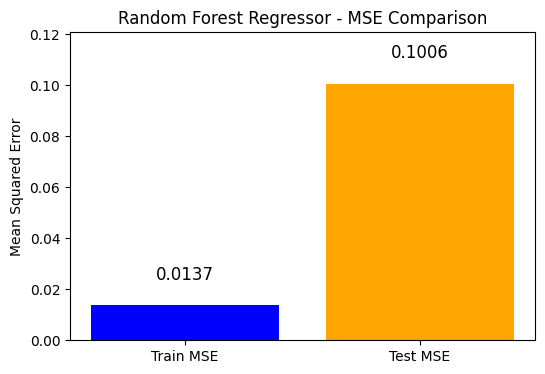

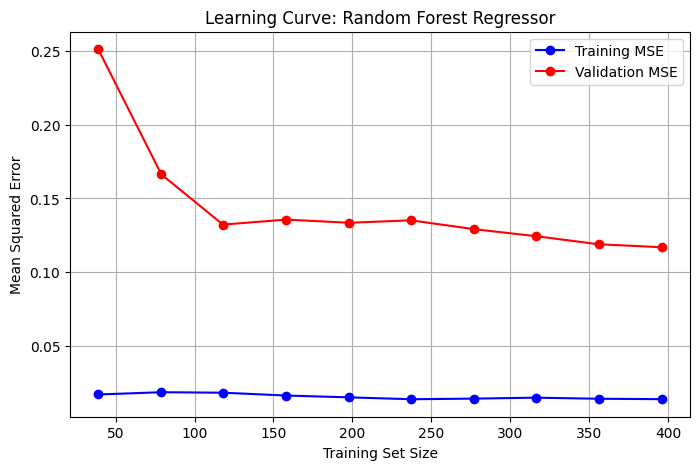

In [11]:
plot_mse_rfr(rfr_model, X_train, X_test, y_train, y_test)
plot_learning_curve_rfr(rfr_model, X, y)

In [12]:
predict_matchup("Eagles", "Chiefs", rfr_model) # This search doesn't necesarrily exclude the matchup during training yet, fix later

Predicted Winner: Eagles (Confidence: 0.55)


'Eagles'

Training Classifier...
Evaluating...
Accuracy: 0.9200

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93        57
           1       0.89      0.93      0.91        43

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100


Top 10 Most Important Features:
                         Feature  Importance
13        passing_avg_yards_diff    0.142952
19            interceptions_diff    0.103619
1          rushing_attempts_diff    0.075205
21                  fumbles_diff    0.072284
27          defense_qb_hits_diff    0.068257
6            punts_attempts_diff    0.047438
2             rushing_yards_diff    0.045907
12    passing_interceptions_diff    0.042188
14      passing_poor_throws_diff    0.040800
15  passing_defended_passes_diff    0.036157


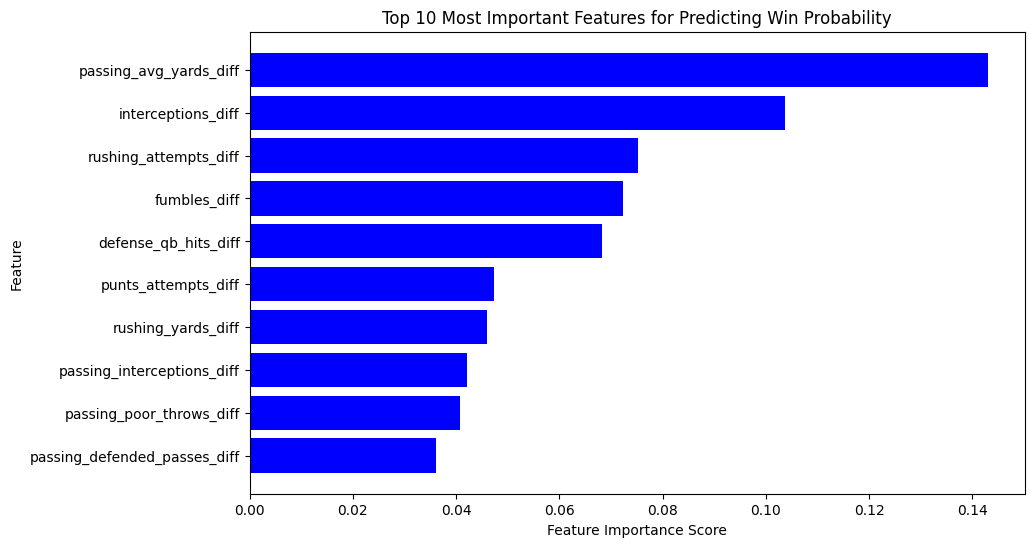

In [15]:
# Random Forest Classifer
# Train Random Forest Classifier
print("Training Classifier...")
rfc_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_classifier.fit(X_train, y_train)

# Predict outcomes
y_pred = rfc_classifier.predict(X_test)

# Evaluate model performance
print("Evaluating...")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importance Analysis
feature_importances = rfc_classifier.feature_importances_
feature_names = X.columns

# Sort features by importance
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Print top features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"][:10], importance_df["Importance"][:10], color="blue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features for Predicting Win Probability")
plt.gca().invert_yaxis()  # Flip to show the most important at the top
plt.show()

In [17]:
def plot_learning_curve_rfc(rfc_model, X, y, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Plots the learning curve showing the training and validation accuracy for different dataset sizes.
    
    Parameters:
    - rfc_model: Trained RandomForestClassifier model
    - X: Feature matrix
    - y: Target labels
    - train_sizes: Percentages of training data to use (default 10% to 100%)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        rfc_model, X, y, train_sizes=train_sizes, cv=5, scoring="accuracy"
    )

    # Compute mean accuracy
    #train_accuracy = train_scores.mean(axis=1)
    test_accuracy = test_scores.mean(axis=1)

    # Plot learning curve
    plt.figure(figsize=(8, 5))
    #plt.plot(train_sizes, train_accuracy, 'o-', color="blue", label="Training Accuracy")
    plt.plot(train_sizes, test_accuracy, 'o-', color="red", label="Validation Accuracy")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve: Random Forest Classifier")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

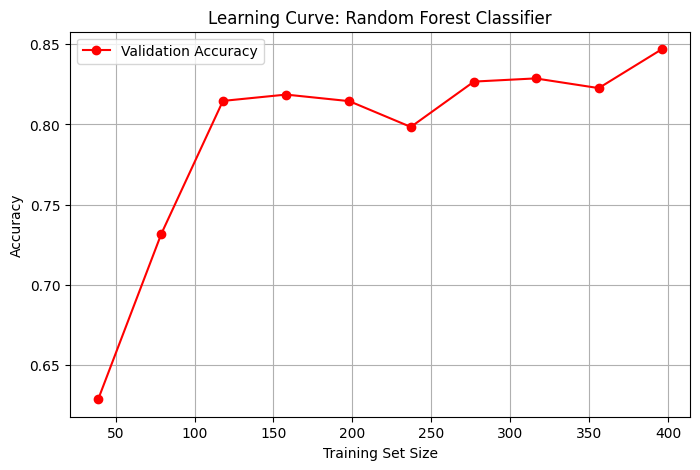

Predicted Winner: Eagles (Confidence: 1.00)


'Eagles'

In [19]:
plot_learning_curve_rfc(rfc_classifier, X, y)
predict_matchup("Eagles", "Chiefs", rfc_classifier)

In [21]:
def plot_learning_curve_ada(ada_model, X, y, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Plots the learning curve showing the training and validation accuracy for different dataset sizes.
    
    Parameters:
    - rfc_model: Trained Adaboost model
    - X: Feature matrix
    - y: Target labels
    - train_sizes: Percentages of training data to use (default 10% to 100%)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        ada_model, X, y, train_sizes=train_sizes, cv=5, scoring="accuracy"
    )

    # Compute mean accuracy
    #train_accuracy = train_scores.mean(axis=1)
    test_accuracy = test_scores.mean(axis=1)

    # Plot learning curve
    plt.figure(figsize=(8, 5))
    #plt.plot(train_sizes, train_accuracy, 'o-', color="blue", label="Training Accuracy")
    plt.plot(train_sizes, test_accuracy, 'o-', color="red", label="Validation Accuracy")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve: AdaBoost")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [23]:
base_estimator = DecisionTreeClassifier(max_depth=1)

# Create the AdaBoost classifier
adaboost = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, algorithm = 'SAMME', random_state=42)

# Train the model
adaboost.fit(X_train, y_train)

# Make predictions
y_pred = adaboost.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.89


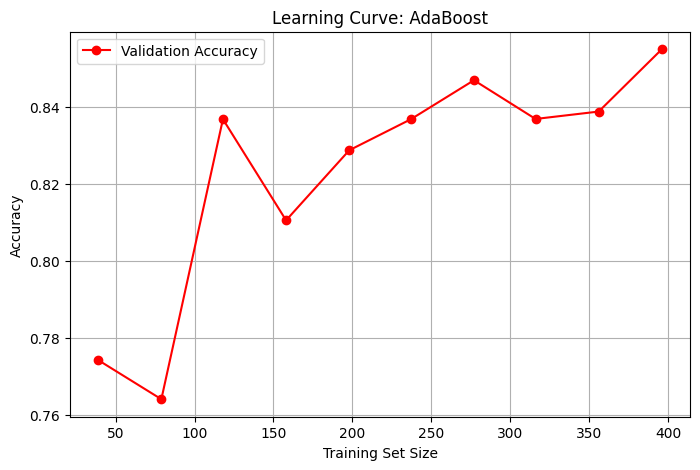

Predicted Winner: Eagles (Confidence: 1.00)


'Eagles'

In [25]:
plot_learning_curve_ada(adaboost, X, y)
predict_matchup("Eagles", "Chiefs", adaboost)

# 2025 SEASON PREDICTION

In [28]:
# retrieve team_stats to predict from
with open("../combined_data.json", 'r') as readfile_combined_data:
        team_stats = json.load(readfile_combined_data)
teams = team_stats.keys()

In [30]:
# this method returns true or false whether team_a wins their football matchup, borrows from predict_matchup()
def isWinner(team_a, team_b, model) -> bool:
    stats_a, stats_b = team_stats[team_a], team_stats[team_b]
    
    feature_diff = {f"{key}_diff": stats_a[key] - stats_b[key] for key in stats_a}
    
    for feature in ["touchdowns_total_diff", "touchdowns_pass_diff", "touchdowns_rush_diff"]:
        feature_diff[feature] = 0

    feature_columns = model.feature_names_in_  # Sklearn 1.0+ stores trained feature names
    input_data = pd.DataFrame([[feature_diff.get(col, 0) for col in feature_columns]], columns=feature_columns)

    prediction = model.predict(input_data)[0]
    if prediction == 0.5:
        return None
    else:
        return prediction > 0.5

In [32]:
forestTeamWins = {team: 0 for team in teams}
adaTeamWins = {team: 0 for team in teams}
forestTeamLosses = {team: 0 for team in teams}
adaTeamLosses = {team: 0 for team in teams}

In [34]:
import csv  # needed to read file containing 2025 season schedule data

In [36]:
with open("../matchups2025season.csv", "r") as scheduleFile:
    scheduleReader = csv.reader(scheduleFile)
    schedules = list(scheduleReader)

In [38]:
for schedule in schedules:
    team = schedule[0]

    for opponent in schedule[1:]:
        wonWithForest = isWinner(team, opponent, rfc_classifier)
        wonWithAda = isWinner(team, opponent, adaboost)

        if wonWithForest is not None:
            if wonWithForest:
                forestTeamWins[team] += 1
            else:
                forestTeamLosses[team] += 1

        if wonWithAda is not None:
            if wonWithAda:
                adaTeamWins[team] += 1
            else:
                adaTeamLosses[team] += 1

*NFL 2025 Season Team Record Predictions by Random Forest Classifer and AdaBoost*

*Format is \<TeamName>: \<RFC Predicted Record>, \<AdaBoost Predicted Record>*

In [40]:
for team in teams:
    fstWs = forestTeamWins[team]
    fstLs = forestTeamLosses[team]
    adaWs = adaTeamWins[team]
    adaLs = adaTeamLosses[team]
    fstTies = 17 - (fstWs + fstLs)
    adaTies = 17 - (adaWs + adaLs)
    fstTieStr = f" - {fstTies}" if fstTies > 0 else ""
    adaTieStr = f" - {adaTies}" if adaTies > 0 else ""
    
    print(f"{team.rjust(10)}: {fstWs} - {fstLs}{fstTieStr},  {adaWs} - {adaLs}{adaTieStr}")

     49ers: 8 - 9,  8 - 9
     Bears: 3 - 14,  4 - 13
   Bengals: 8 - 9,  8 - 9
     Bills: 15 - 2,  15 - 2
   Broncos: 8 - 9,  9 - 8
    Browns: 0 - 17,  0 - 17
Buccaneers: 10 - 7,  10 - 7
 Cardinals: 5 - 12,  7 - 10
  Chargers: 10 - 7,  11 - 6
    Chiefs: 10 - 7,  14 - 3
     Colts: 5 - 12,  5 - 12
Commanders: 13 - 4,  9 - 8
   Cowboys: 6 - 11,  6 - 11
  Dolphins: 7 - 10,  8 - 9
    Eagles: 15 - 2,  14 - 3
   Falcons: 10 - 7,  5 - 12
    Giants: 0 - 17,  0 - 17
   Jaguars: 2 - 15,  2 - 15
      Jets: 4 - 13,  5 - 12
     Lions: 17 - 0,  17 - 0
   Packers: 10 - 7,  10 - 7
  Panthers: 1 - 16,  2 - 15
  Patriots: 4 - 13,  3 - 14
   Raiders: 5 - 12,  6 - 11
      Rams: 7 - 10,  8 - 9
    Ravens: 15 - 2,  15 - 2
    Saints: 8 - 9,  11 - 6
  Seahawks: 4 - 13,  3 - 14
  Steelers: 10 - 7,  10 - 7
    Texans: 9 - 8,  12 - 5
    Titans: 5 - 12,  1 - 16
   Vikings: 10 - 7,  14 - 3
